# WSB reddit posts

## Libraries

In [ ]:
# Dataframes and viz libraries
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from collections import defaultdict

# Counting words, wordclouds and getting image
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
import requests
from PIL import *

# Text cleaning
import regex as re
import nltk
from nltk import (
    word_tokenize,
    BigramAssocMeasures,
    BigramCollocationFinder,
    TrigramAssocMeasures,
    TrigramCollocationFinder,
)
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download("wordnet")
nltk.download("punkt")
nltk.download("omw-1.4")
nltk.download("stopwords")
stop = stopwords.words("english")

# Topic Modelling
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer

## Data

In [4]:
# Getting the data
wsb_com = pd.read_csv("../wsb-topic/Data/reddit_wsb.csv")

In [5]:
# How many columns/rows
print(wsb_com.shape)

(33224, 8)


In [6]:
# A random head of the dataset
wsb_com.sample(5)

,title,score,id,url,comms_num,created,body,timestamp
134,Where is the loss porn?,602,l6oeoq,https://www.reddit.com/r/wallstreetbets/commen...,218,1.611838e+09,Maybe I'm the only one who's noticed. But thi...,2021-01-28 14:54:13
27125,I heard y’all like loss porn?,24,ld07lc,https://i.redd.it/y8p77ixwflf61.jpg,11,1.612531e+09,NaN,2021-02-05 15:19:30
28445,Stimulus Check is Looming,11,ld0oy9,https://www.reddit.com/r/wallstreetbets/commen...,29,1.612533e+09,To all my fellow American apes. We had your ba...,2021-02-05 15:51:23
25384,GME shortsqueeze and what comes next part 2,76,lcfxiz,https://www.reddit.com/r/wallstreetbets/commen...,15,1.612475e+09,"Wasn't allowed to crosspost from r/stocks, so ...",2021-02-04 23:44:46
25657,What app should I use,0,lcadd8,https://www.reddit.com/r/wallstreetbets/commen...,21,1.612452e+09,I really wanna start investing but was unable ...,2021-02-04 17:27:48


In [7]:
# Formating the date column
wsb_com["date"] = pd.to_datetime(wsb_com["timestamp"]).dt.to_period("D")
wsb_com["date"] = wsb_com["date"].astype(str)

## First analysis

### Posts

In [8]:
# Counting posts by the date
posts_bytime = wsb_com.groupby(["date"])["id"].count().reset_index()
posts_bytime.columns = ["Date", "Number"]
posts_bytime.Number.sum()

33224

In [10]:
# Posts chart
fig = px.bar(
    posts_bytime,
    x="Date",
    y="Number",
    color_discrete_sequence=["darkslategray"],
    title="<b>Posts by day on WallStreetBets subreddit (from January 28 to February 15)<b>",
    orientation="v",
    text="Number",
    width=800,
    height=400,
)
# Remove x axes from the fig
fig.update_yaxes(visible=False, showticklabels=False)
fig.update_xaxes(
    tickfont_family="Charter", ticks="outside", tickcolor="white", ticklen=10
)
fig.update_traces(textposition="outside", textfont_size=11)

# Put the title in the middle
fig.update(layout=dict(title=dict(x=0.5, y=0.95)))
# Remove the legend and put the background in white
fig.update_layout(
    showlegend=False,
    plot_bgcolor="white",
    yaxis=dict(title=""),
    margin=dict(autoexpand=True, l=10, r=1, t=50, b=80),
    font=dict(family="Charter", size=13, color="darkslategray"),
)
fig.show()

### Scores

What is the score ?

A submission's score is simply the number of upvotes minus the number of downvotes. If five users like the submission and three users don't it will have a score of 2. Please note that the vote numbers are not "real" numbers, they have been "fuzzed" to prevent spam bots etc. So taking the above example, if five users upvoted the submission, and three users downvote it, the upvote/downvote numbers may say 23 upvotes and 21 downvotes, or 12 upvotes, and 10 downvotes. The points score is correct, but the vote totals are "fuzzed" (reddit.com).

In [11]:
# Score distribution
wsb_com.score.describe()

count     33224.000000
mean       1031.769173
std        7730.636984
min           0.000000
25%           1.000000
50%          10.000000
75%         112.000000
max      348241.000000
Name: score, dtype: float64

In [12]:
# Looking the top scores
pd.options.display.max_colwidth = 100

titles = pd.DataFrame(wsb_com[["title", "score"]])
titles.sort_values(by=["score"], ascending=False, inplace=True)
titles[:10]

,title,score
19162,Times Square right now,348241
16009,GME YOLO update — Jan 28 2021,225870
17771,GME YOLO month-end update — Jan 2021,219779
18273,It’s treason then,195782
18069,"Used some of my GME tendies to buy Nintendo Switches from Gamestop, then donated them to a Child...",192980
32168,Wow super bowl commercial for us,191380
18230,That’s what I thought,175665
16220,IT'S POWER TO THE TRADERS NOW,174401
18826,I am proud to do my part in paying forward our good fortune with a donation of 6 Nintendo Switch...,171778
19712,Drew this for you my fellow retards 💎🙌🏼,171545


### Comments

In [13]:
# Comments distribution
wsb_com.comms_num.describe()

count    33224.000000
mean       129.680171
std       1866.746311
min          0.000000
25%          1.000000
50%          7.000000
75%         31.000000
max      89050.000000
Name: comms_num, dtype: float64

In [14]:
# Top posts by comments
coms = pd.DataFrame(wsb_com[["title", "id", "comms_num"]])
coms.sort_values(by="comms_num", inplace=True, ascending=False)
posts10 = coms[:10]

In [16]:
# Comments chart
fig = px.funnel(
    posts10,
    x="comms_num",
    y="title",
    color_discrete_sequence=["darkslategray"],
    title="<b>Top 10 posts by comments<b>",  # , #orientation='v'
    width=800,
    height=400,
)
# Remove x axes from the fig
# fig.update_yaxes(visible=False, showticklabels=False)
fig.update_xaxes(
    tickfont_family="Charter", ticks="outside", tickcolor="white", ticklen=10
)
fig.update_traces(textposition="inside", textfont_size=11)

# Put the title in the middle
fig.update(layout=dict(title=dict(x=0.825, y=0.92)))
# Remove the legend and put the background in white
fig.update_layout(
    showlegend=False,
    plot_bgcolor="white",
    yaxis=dict(title=""),
    margin=dict(autoexpand=True, l=100, r=20, t=60, b=30),
    font=dict(family="Charter", size=13, color="darkslategray"),
)
fig.show()

## Corpus Cleaning

In [17]:
# A function to clean texts
def clean_text(text):

    text = str(text)
    text = text.lower()

    text = re.sub(r"http\S+", " ", text)
    text = re.sub(r"\b[a-zA-Z]\b", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"[^a-zA-Z0-9]+", " ", text)
    text = re.sub(r"\s+", " ", text)

    text = text.split()

    return text

In [18]:
# Creating a dataframe with bodies
body_df = wsb_com[["body"]]
body_df.sample(2)

,body
9549,NaN
11779,NaN


In [19]:
# Checking NaN values
print(body_df.isnull().sum())

body    15787
dtype: int64


In [20]:
# Droping NaN values
body_df_clean = body_df.dropna().copy()

In [21]:
# Checking NaN values
print(body_df_clean.isnull().sum())

body    0
dtype: int64


In [40]:
# Cleaning bodies and removing stopwords
body_df_clean = pd.DataFrame(body_df_clean.body.apply(lambda x: clean_text(x)))
body_df_clean.body = body_df_clean.body.apply(
    lambda x: " ".join([word for word in x if word not in (stop)])
)

In [41]:
# Tokenizing and Lemmatizing the bodies
lemmer = WordNetLemmatizer()
body_df_clean.body = body_df_clean.body.apply(lambda x: word_tokenize(x))
body_df_clean.body = body_df_clean.body.apply(
    lambda x: [lemmer.lemmatize(y) for y in x]
)
body_df_clean.body = body_df_clean.body.apply(lambda x: " ".join(x))
body_df_clean.reset_index(inplace=True)
body_df_clean.drop(columns=["index"], inplace=True)

### Word frequency (wordcloud)

In [42]:
# Counting the frequency of each word
words_count = Counter(word_tokenize("\n".join(body_df_clean.body)))

In [43]:
# Downloading an image from an url
image_url = "https://cdn.shopify.com/s/files/1/0072/7315/2579/products/classic-wallstreetbets-kid-kiss-cut-sticker-55x55-inch-wallstreetbets.jpg?v=1606625344"
image = Image.open(requests.get(image_url, stream=True).raw)
# Converting the image to a numeric representation
mask = np.array(image)
# For the colours of the wordclouds text
image_colours = ImageColorGenerator(mask)

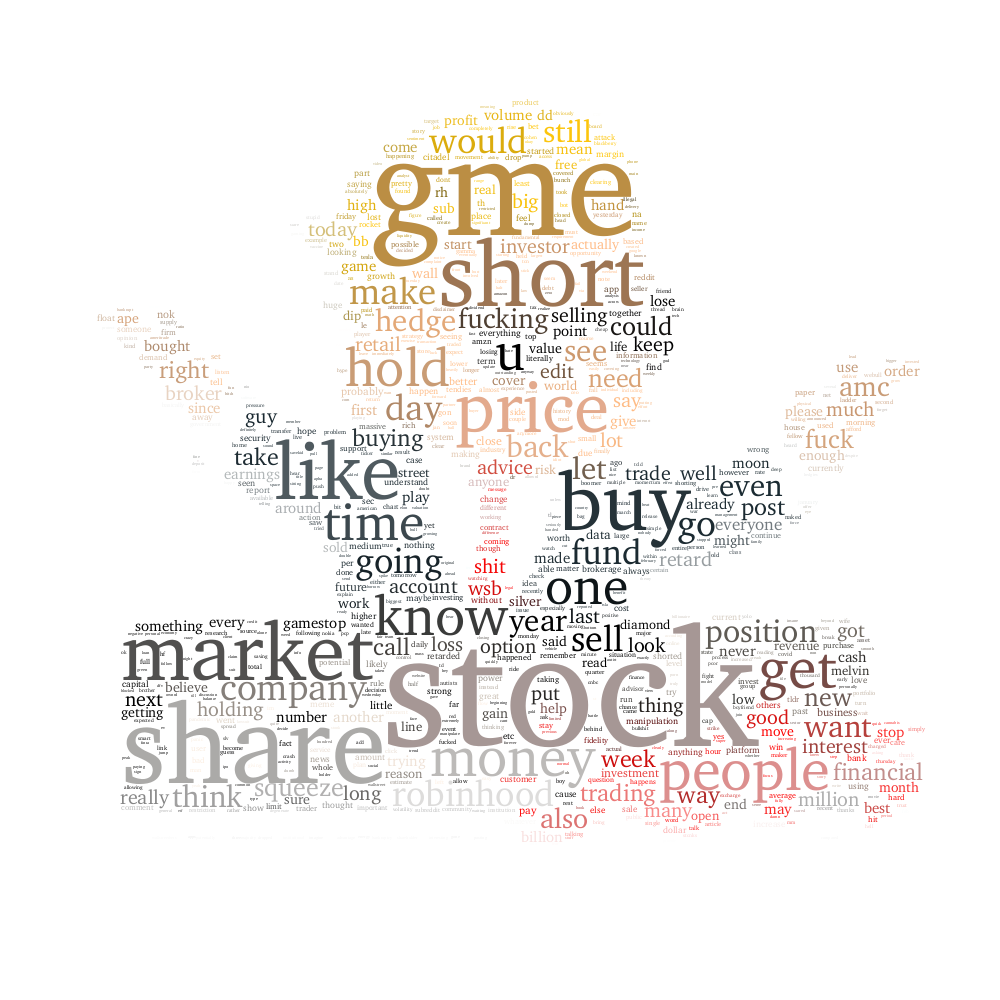

In [44]:
# WSB wordcloud
wc = WordCloud(
    font_path="../wsb-topic/Utils/Charter.ttf",
    color_func=image_colours,
    mask=mask,
    max_words=2000,
    background_color="white",
    prefer_horizontal=1,
)
# Generate the cloud using a frequency dictionary
wc.generate_from_frequencies(words_count)
wc.to_image()

## NMF

### Topic on titles

In [45]:
# Creating a dataframe with titles
title_df = wsb_com[["title"]]
title_df.sample(2)

,title
1397,I think Robinhood will take the fall for the GME squeeze
30906,some of you are so angry about the United Apes of America & International Ape Association coming...


In [46]:
# Looking for NaN values
print(title_df.isnull().sum())

title    0
dtype: int64


In [47]:
# Cleaning titles and removing stopwords
title_df_clean = pd.DataFrame(title_df.title.apply(lambda x: clean_text(x)))
title_df_clean.title = title_df_clean.title.apply(
    lambda x: " ".join([word for word in x if word not in (stop)])
)

In [48]:
# Tokenizing and Lemmatizing the titles
lemmer = WordNetLemmatizer()
title_df_clean.title = title_df_clean.title.apply(lambda x: word_tokenize(x))
title_df_clean.title = title_df_clean.title.apply(
    lambda x: [lemmer.lemmatize(y) for y in x]
)
title_df_clean.title = title_df_clean.title.apply(lambda x: " ".join(x))

In [49]:
# A sample of the new data
title_df_clean.sample(2)

,title
17867,tfw paid interest month autists lost entire existence wsb
3771,call local senator house rep


In [50]:
# Using TFIDF to remove least frequent tokens (min frequency = 50)
vectors = TfidfVectorizer(min_df=50, stop_words="english")

# Fitting and transforming
X = vectors.fit_transform(title_df_clean.title)

In [51]:
# Creating a NMF model
# Getting 5 topics (n_components = 5)
model = NMF(n_components=5, random_state=5)

# Fitting the model
model.fit(X)

/usr/local/anaconda3/envs/envN/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



NMF(n_components=5, random_state=5)

In [52]:
# Creating a dataframe from the results of the model
components_df = pd.DataFrame(model.components_, columns=vectors.get_feature_names())

/usr/local/anaconda3/envs/envN/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [53]:
# A list of topic labels
topics = [
    "Title Topic 1",
    "Title Topic 2",
    "Title Topic 3",
    "Title Topic 4",
    "Title Topic 5",
]

In [54]:
# Getting the topics into a dictionnary of dataframe
dict_topic = {}
for name, topic in zip(topics, range(components_df.shape[0])):
    dict_topic[name] = pd.DataFrame(components_df.iloc[topic].nlargest(10))
    dict_topic[name].columns = ["Coefficient"]
    dict_topic[name].sort_values(by="Coefficient", ascending=True, inplace=True)

In [57]:
# A function that will plot the words and their coefficient
def create_plot(topic, color):
    fig = px.bar(
        dict_topic[topic],
        x="Coefficient",
        y=dict_topic[topic].index,
        color_discrete_sequence=[color],
        title=topic,
        orientation="h",
        width=800,
        height=400,
    )
    # Remove x axes from the fig
    # fig.update_xaxes(visible=False, showticklabels=False)
    fig.update_yaxes(
        tickfont_family="Charter", ticks="outside", tickcolor="white", ticklen=10
    )
    fig.update_traces(textposition="inside", textfont_size=11)

    # Put the title in the middle
    fig.update(layout=dict(title=dict(x=0.128, y=0.92)))
    # Remove the legend and put the background in white
    fig.update_layout(
        showlegend=False,
        plot_bgcolor="white",
        yaxis=dict(title=""),
        margin=dict(autoexpand=True, l=100, r=20, t=60, b=30),
        font=dict(family="Charter", size=13, color=color),
    )
    fig.show()

In [58]:
# Topics of titles
for topic in topics:
    create_plot(topic, "darkslategray")

### Topic on content

In [59]:
# Using TFIDF to remove least frequent tokens (min frequency = 50)
vectors = TfidfVectorizer(min_df=50, stop_words="english")

# Fitting and transforming
X = vectors.fit_transform(body_df_clean.body)

In [60]:
# Creating a NMF model
# Getting 5 topics (n_components = 5)
model = NMF(n_components=5, random_state=5)

# Fitting the model
model.fit(X)

/usr/local/anaconda3/envs/envN/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



NMF(n_components=5, random_state=5)

In [61]:
# Creating a dataframe from the results of the model
components_df = pd.DataFrame(model.components_, columns=vectors.get_feature_names())

/usr/local/anaconda3/envs/envN/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [62]:
# A list of topic labels
topics = [
    "Body Topic 1",
    "Body Topic 2",
    "Body Topic 3",
    "Body Topic 4",
    "Body Topic 5",
]

In [63]:
# Getting the topics into a dictionnary of dataframe
dict_topic = {}
for name, topic in zip(topics, range(components_df.shape[0])):
    dict_topic[name] = pd.DataFrame(components_df.iloc[topic].nlargest(10))
    dict_topic[name].columns = ["Coefficient"]
    dict_topic[name].sort_values(by="Coefficient", ascending=True, inplace=True)

In [64]:
# Topics of bodies
for topic in topics:
    create_plot(topic, "darkslategray")

## Bi-grams

### Titles

In [65]:
# A function to get bigrams
def get_bigrams(Tokens, freqThreshold):
    bigrams_ = defaultdict(int)

    b = nltk.collocations.BigramCollocationFinder.from_words(Tokens)
    b.apply_freq_filter(freqThreshold)
    for bigram, freq in b.ngram_fd.items():

        bigram = " ".join([bigram[0], bigram[1]])
        bigrams_[bigram] = freq
    return bigrabigrams_ms_in_movie

In [66]:
# Tokenizing and getting the bigrams
nltk_tokens = nltk.word_tokenize("\n".join(title_df_clean.title))
titles_bigrams = ["_".join(b) for b in nltk.bigrams(nltk_tokens)]

In [67]:
# Bigrams size
len(titles_bigrams)

197396

In [68]:
# Frequency of bigrams
titles_bigFreq = nltk.FreqDist(titles_bigrams)

In [69]:
# Bigrams dataframe
title_freq = pd.DataFrame.from_dict(titles_bigFreq, orient="index").reset_index()
title_freq.columns = ["Word", "Frequency"]
title_freq.sort_values(by=["Frequency"], inplace=True, ascending=False)
title_freq["Frequency"] = title_freq["Frequency"].astype(int).apply(lambda x: f"{x:,}")
title_freq2 = title_freq.head(10)

In [71]:
# Titles bigrams chart
fig = px.funnel(
    title_freq2,
    x="Frequency",
    y="Word",
    color_discrete_sequence=["darkslategray"],
    title="<b>Top 10 titles bigrams<b>",  # , #orientation='v'
    width=800,
    height=400,
)
# Remove x axes from the fig
# fig.update_yaxes(visible=False, showticklabels=False)
fig.update_xaxes(
    tickfont_family="Charter", ticks="outside", tickcolor="white", ticklen=10
)
fig.update_traces(textposition="inside", textfont_size=11)

# Put the title in the middle
fig.update(layout=dict(title=dict(x=0.57, y=0.92)))
# Remove the legend and put the background in white
fig.update_layout(
    showlegend=False,
    plot_bgcolor="white",
    yaxis=dict(title=""),
    margin=dict(autoexpand=True, l=100, r=20, t=60, b=30),
    font=dict(family="Charter", size=13, color="darkslategray"),
)
fig.show()

### Bodies

In [72]:
# Tokenizing and getting the bigrams
nltk_tokens = nltk.word_tokenize("\n".join(body_df_clean.body))
bodies_bigrams = ["_".join(b) for b in nltk.bigrams(nltk_tokens)]

In [73]:
# Bigrams size
len(bodies_bigrams)

1087400

In [74]:
# Frequency of bigrams
bodies_bigFreq = nltk.FreqDist(bodies_bigrams)

In [75]:
# Bigrams dataframe
body_freq = pd.DataFrame.from_dict(bodies_bigFreq, orient="index").reset_index()
body_freq.columns = ["Word", "Frequency"]
body_freq.sort_values(by=["Frequency"], inplace=True, ascending=False)
body_freq["Frequency"] = body_freq["Frequency"].astype(int).apply(lambda x: f"{x:,}")
body_freq2 = body_freq.head(10)

In [77]:
# Bodies bigrams chart
fig = px.funnel(
    body_freq2,
    x="Frequency",
    y="Word",
    color_discrete_sequence=["darkslategray"],
    title="<b>Top 10 bodies bigrams<b>",  # , #orientation='v'
    width=800,
    height=400,
)
# Remove x axes from the fig
# fig.update_yaxes(visible=False, showticklabels=False)
fig.update_xaxes(
    tickfont_family="Charter", ticks="outside", tickcolor="white", ticklen=10
)
fig.update_traces(textposition="inside", textfont_size=11)

# Put the title in the middle
fig.update(layout=dict(title=dict(x=0.57, y=0.92)))
# Remove the legend and put the background in white
fig.update_layout(
    showlegend=False,
    plot_bgcolor="white",
    yaxis=dict(title=""),
    margin=dict(autoexpand=True, l=100, r=20, t=60, b=30),
    font=dict(family="Charter", size=13, color="darkslategray"),
)
fig.show()

### Bigrams titles topics

In [78]:
# Transforming into bigrams
def withbigrams(text):
    nltk_tokens = nltk.word_tokenize(text)
    test = ["_".join(b) for b in nltk.bigrams(nltk_tokens)]
    return test

In [79]:
# Titles df with bigrams
title_df_clean["title2"] = title_df_clean.title.apply(lambda x: withbigrams(x))
title_df_clean["title2"] = title_df_clean["title2"].apply(lambda x: " ".join(x))
title_df_clean.sample(2)

,title,title2
8861,sell liquidate buy dip,sell_liquidate liquidate_buy buy_dip
12786,brazilian helping bought gme financial advisor position,brazilian_helping helping_bought bought_gme gme_financial financial_advisor advisor_position


In [80]:
# Using TFIDF to remove least frequent tokens (min frequency = 50)
vectors = TfidfVectorizer(min_df=50, stop_words="english")

# Fitting and transforming
X = vectors.fit_transform(title_df_clean["title2"])

In [81]:
# Creating a NMF model
# Getting 5 topics (n_components = 5)
model = NMF(n_components=5, random_state=5)

# Fitting the model
model.fit(X)

/usr/local/anaconda3/envs/envN/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



NMF(n_components=5, random_state=5)

In [82]:
# Creating a dataframe from the results of the model
components_df = pd.DataFrame(model.components_, columns=vectors.get_feature_names())

/usr/local/anaconda3/envs/envN/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [83]:
# A list of topic labels
topics = [
    "Body Bigrams Topic 1",
    "Body Bigrams Topic 2",
    "Body Bigrams Topic 3",
    "Body Bigrams Topic 4",
    "Body Bigrams Topic 5",
]

In [84]:
# Getting the topics into a dictionnary of dataframe
dict_topic = {}
for name, topic in zip(topics, range(components_df.shape[0])):
    dict_topic[name] = pd.DataFrame(components_df.iloc[topic].nlargest(10))
    dict_topic[name].columns = ["Coefficient"]
    dict_topic[name].sort_values(by="Coefficient", ascending=True, inplace=True)

In [85]:
# Topics of bodies
for topic in topics:
    create_plot(topic, "midnightblue")

### Bigrams bodies topics

In [86]:
# Bodies df with bigrams
body_df_clean["body2"] = body_df_clean.body.apply(lambda x: withbigrams(x))
body_df_clean["body2"] = body_df_clean["body2"].apply(lambda x: " ".join(x))
body_df_clean.sample(2)

,body,body2
8027,thats moon,thats_moon
11921,panicked sold today week id like dd bb one good long term play meme stock im encouraging sell cu...,panicked_sold sold_today today_week week_id id_like like_dd dd_bb bb_one one_good good_long long...


In [87]:
# Using TFIDF to remove least frequent tokens (min frequency = 50)
vectors = TfidfVectorizer(min_df=50, stop_words="english")

# Fitting and transforming
X = vectors.fit_transform(body_df_clean["body2"])

In [88]:
# Creating a NMF model
# Getting 5 topics (n_components = 5)
model = NMF(n_components=5, random_state=5)

# Fitting the model
model.fit(X)

/usr/local/anaconda3/envs/envN/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



NMF(n_components=5, random_state=5)

In [89]:
# Creating a dataframe from the results of the model
components_df = pd.DataFrame(model.components_, columns=vectors.get_feature_names())

/usr/local/anaconda3/envs/envN/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [90]:
# A list of topic labels
topics = [
    "Title Bigrams Topic 1",
    "Title Bigrams Topic 2",
    "Title Bigrams Topic 3",
    "Title Bigrams Topic 4",
    "Title Bigrams Topic 5",
]

In [91]:
# Getting the topics into a dictionnary of dataframe
dict_topic = {}
for name, topic in zip(topics, range(components_df.shape[0])):
    dict_topic[name] = pd.DataFrame(components_df.iloc[topic].nlargest(10))
    dict_topic[name].columns = ["Coefficient"]
    dict_topic[name].sort_values(by="Coefficient", ascending=True, inplace=True)

In [92]:
# Topics of bodies
for topic in topics:
    create_plot(topic, "midnightblue")